# Naive Bayes and Logistic Regreession and Comparison of both classifier

## Data Description

To implement the classifier and its comparison, I picked the following Data set -

-Dataset: 
Banknote authentication Data Set from UCI Machine Learning Repository   
                                                                                                                                                                                                                                                                                                                                                                 
-Data Set Information: 
Data were extracted from images that were taken from genuine and forged banknote-like specimens. For digitization, an industrial camera usually used for print inspection was used. The final images have 400x 400 pixels. Due to the object lens and distance to the investigated object gray-scale pictures with a resolution of about 660 dpi were gained. Wavelet Transform tool were used to extract features from images.

-Attribute Information:
1. variance of Wavelet Transformed image (continuous) 
2. skewness of Wavelet Transformed image (continuous) 
3. curtosis of Wavelet Transformed image (continuous) 
4. entropy of image (continuous) 
5. class (integer) 

-Number of Instances : 1372

-Task : 
Build two classifier using Naive Bayes and Logistic Regression which is able to classify whether a bank note is Authenticated or not and compare both classifier.
In our dataset 'class' column has two values. I assume that '1' is indicated for authenticate note and '0' is label for not aunthenticated note. So 'class' value is a target vairable. 
-Link for Dataset: https://archive.ics.uci.edu/ml/datasets/banknote+authentication


In [16]:
#importing required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as sm

In [17]:
# reading the file and saving it into data variable
data = pd.read_csv('data_banknote_authentication.txt', sep=',',header=None, names=["variance","skewness","curtosis","entropy","class"])

### a) Understanding the Data

In [18]:
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Here we can see that data might be not shuffled, So I went through the whole data and found that in this data, column 'class' has first all 0s value and after that all 1s value, that mean rows are not random and in sequence. So it is necessary to shuffle the data before splitting the data into training set and testing set.

To get the idea of basic statistics of each column I thought to use describe function. It will also give a minor idea of any column has more 0s values. For example for any column if 25% has 0 value that mean 25% data of that column is 0.
It also gives the idea about how much maximum and minimum value differs from the mean. 

In [45]:
data.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [46]:
# to see if any  column has the missing values
data.isnull().any()

variance    False
skewness    False
curtosis    False
entropy     False
class       False
dtype: bool

Here data's columns do not have the missing values. That's a good news!
Now as 'class' attribute is target attribute, It is also required to check the amount of distribution of both classes(0 and 1) in the 'class' attribute. It they will be very uneven for example if percentage of authenticated is 8% and not authenticated note is 92% then I think Naive Bayes might not work good. So it will be interesting to see what is the percentage of both classes (0s and 1s) in this 'class' column.

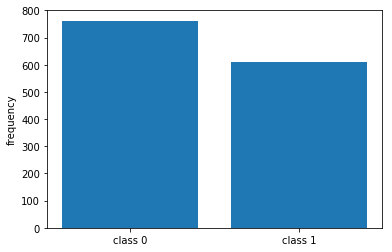

In [21]:
# Target vaiable is class and plotting the class variable
class_freq=data['class'].value_counts()
labels=["class 0","class 1"]
values=[class_freq[0],class_freq[1]]
plt.bar(labels,values)
plt.ylabel("frequency")
plt.show()

Distribution of both classes are not same but not very uneven so it will be fine to implement Naive Bayes classifier.

### b) Distribution of the columns 

variance       AxesSubplot(0.125,0.536818;0.352273x0.343182)
skewness    AxesSubplot(0.547727,0.536818;0.352273x0.343182)
curtosis          AxesSubplot(0.125,0.125;0.352273x0.343182)
entropy        AxesSubplot(0.547727,0.125;0.352273x0.343182)
dtype: object

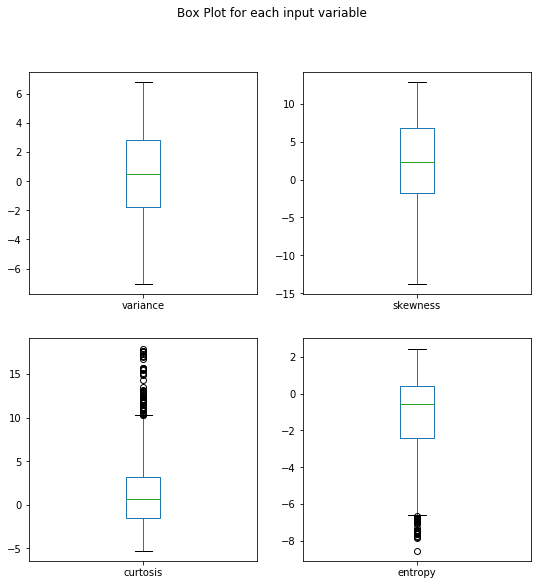

In [22]:
#box plot for each covariate column
data.drop('class',axis=1).plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False, figsize=(9,9), title='Box Plot for each input variable')

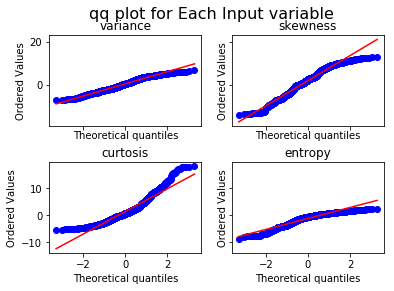

In [23]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.suptitle('qq plot for Each Input variable',size = 16)
stats.probplot(data["variance"], plot=ax1)
ax1.set_title("variance")
stats.probplot(data["skewness"], plot=ax2)
ax2.set_title("skewness")
stats.probplot(data["curtosis"], plot=ax3)
ax3.set_title("curtosis")
stats.probplot(data["entropy"], plot=ax4)
ax4.set_title("entropy")
f.subplots_adjust(hspace=0.4)

From the qqplot and box plots we can observe following result : 
1. 'variance' - Almost Normally distributed
2. 'skewness' - Almost nirmally distributed but litle bit skewed on left tail
3. 'curtosis' - It is not following the normal distriution at all and also skewed on right tail
4. 'entropy'  - 'It is also not normally distributed' and skewed on the left tail. 


### c) Distibution of different class(class 0 and class 1) in different covariates

After seeing the distribution of the classes. It is also very important to see the distribution of both classes in each variable
to know :                                                                                                                       
1) What type of transformation we need to do to make the distribution Gaussian. (as our covariates are continuous number so it will be good to implement Gaussian Naive bayes and to implement this, distribution of columns and distribution of category(0 and 1) among columns should be normally distributed.)                                                                                     
2) Correlation between columns (As Naive bayes assumes that columns are independent) 

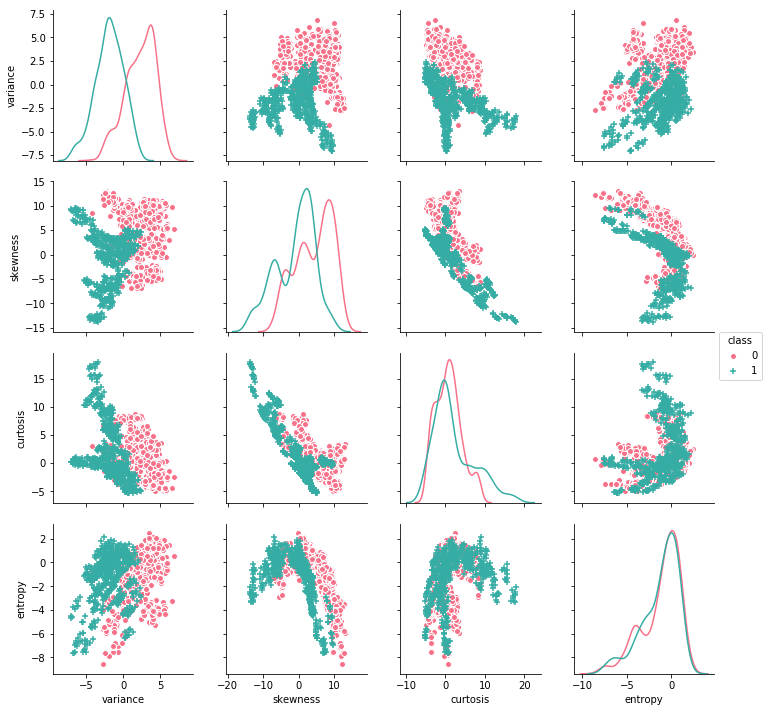

In [24]:
g = sns.pairplot(data,vars=["variance","skewness","curtosis","entropy"],hue="class", palette="husl", markers=["o", "+"],diag_kind="kde")

From this plot, followings are the observations can be made: 
* Here we can see that it might be case that 'variance' is going to be most significant covariate to decide the category, as there is very less overlapping of both classes(0 and 1) as compared to other attributes/covariates. 
*  In "entropy of image" attribute, it is very difficult to differentiate between both classes. "Overlap" of the distribution can be seen so it is not easy to classify.
* 'curtosis' and 'entropy' has high correlation.
* "Variance of Wavelet" attribute it is somehow able to classify the target.

In [25]:
#seperating covariates
data_split=data
attribute_X=data_split.drop(columns=['class'])
#seperating target variable
target_y=data_split.drop(columns=['variance','skewness','curtosis','entropy'])
#seperation of test data and training data in 30:70 ratio
X_train, X_test, y_train, y_test = train_test_split( attribute_X, target_y, test_size=0.30, random_state=42)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (960, 4)
y_train (960, 1)
X_test (412, 4)
y_test (412, 1)


##  1) Naive Bayes
For Gaussian naive bayes, It is important that both classes(0 and 1) are normal distributed in all covariates, So I tried to tranformed the column but as columns has negative values. It is not possible to tranform that. 
So I have tried to implement Gaussian Naive bayes. As two column are normally distributed and columns have numeric value.  

#### Naive bayes using all the covariates

In [26]:
gnb = GaussianNB()
#fitting the data
nb_model = gnb.fit(X_train, y_train.values.ravel()) 

In [27]:
# accuracy
predicted = nb_model.predict(X_test)
list_test=[i for i, j in zip(y_test.values.ravel(), predicted) if i == j]
accuracy_percentage=(len(list_test)/len(y_test))
print("Accuracy Percentage",accuracy_percentage)
print ("Confusion Matrix",confusion_matrix(y_test, predicted))

Accuracy Percentage 0.837378640776699
Confusion Matrix [[207  22]
 [ 45 138]]


Here we can see that number of False negative is 22 which is a large number in small sample and can be dangerous because it would be very great loss if any bank note is not authenticated and our classifier is indicated it as a authenticated one.  
So we need to reduce it. 
After analysing the pair plot we can see that 'curtosis' and 'entroy' has high correlation. So we can drop one of them. but after observing the pairplot I have decided to drop both 'curtosis' and 'entropy' attribute as it is not gussian distributed and if we see the scatter plot of this attribute we can see that these covariates won't be more significant to predict the class.


#### Naive bayes using 2 the covariates (without curtosis)

In [47]:
#seperating covariates
data_split_g=data
attribute_X_c=data_split_g.drop(columns=['class','curtosis','entropy'])
#seperating target variable
target_y_c=data_split_g.drop(columns=['variance','skewness','curtosis','entropy'])
#seperation of test data and training data in 30:70 ratio and having same random_state for same sample 
X_train_c, X_test_c, y_train_c,y_test_c = train_test_split( attribute_X_c, target_y_c, test_size=0.30, random_state=42)
print("X_train",X_train_c.shape)
print("y_train",y_train_c.shape)
print("X_test",X_test_c.shape)
print("y_test",y_test_c.shape)

X_train (960, 2)
y_train (960, 1)
X_test (412, 2)
y_test (412, 1)


In [29]:
#fitting the data
nb_model_c = gnb.fit(X_train_c, y_train_c.values.ravel()) 

In [30]:
# accuracy
predicted_c = nb_model_c.predict(X_test_c)
list_test_c=[i for i, j in zip(y_test_c.values.ravel(), predicted_c) if i == j]
accuracy_percentage_c=(len(list_test_c)/len(y_test_c))
print("accuracy_percentage",accuracy_percentage_c)

accuracy_percentage 0.8592233009708737


### a) Confusion Matrix

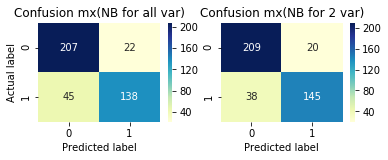

In [31]:
#_confusion matrix
plt.subplot(2,2,1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predicted)), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion mx(NB for all var)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.subplot(2,2,2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test_c, predicted_c)), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion mx(NB for 2 var)')
#plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Here we can see that accuracy of classifier having two covariates is more but False positive value is not very significantly less. 

### b) Confidence Interval

Confidence interval for classifier having all covariates:  (0.7986096372427409, 0.8698167826021104)
Confidence interval for classifier having 2 covariates:  (0.822267105704815, 0.8894392406168946)


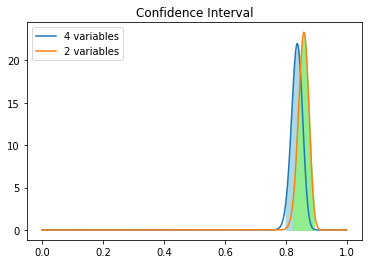

In [32]:
a=1
b=1
correct_pred=len(list_test)
wrong_result=len(y_test) - correct_pred
posterior = stats.beta(correct_pred + a, wrong_result + b)
print("Confidence interval for classifier having all covariates: ",posterior.interval(0.95))
correct_pred=len(list_test_c)
wrong_result=len(y_test_c) - correct_pred
posterior_c = stats.beta(correct_pred + a, wrong_result + b)
print("Confidence interval for classifier having 2 covariates: ",posterior_c.interval(0.95))
#Confidence Interval
p_range = np.arange(0, 1, 0.001)
low, high = posterior.interval(0.95)
low_c, high_c = posterior_c.interval(0.95)
plt.plot(p_range, posterior.pdf(p_range) ,label="4 variables")
plt.plot(p_range, posterior_c.pdf(p_range), label="2 variables")
between = np.arange(low, high+0.01, 0.01)
plt.fill_between(between, posterior.pdf(between), color='lightblue')
between = np.arange(low_c, high_c+0.01, 0.01)
plt.fill_between(between, posterior_c.pdf(between), color='lightgreen')
plt.title("Confidence Interval")
plt.legend()
plt.show()

### c) cross validation (to get a more reliable estimate and tighter interval)

In [33]:
# cross validation for all variables
scores = cross_val_score(gnb, attribute_X, target_y.values.ravel(), cv=10)
print("*********Accurracy for all covariates********")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Acuuracy range :", np.min(scores),"-",np.max(scores))
print("*********Accurracy for two covariates********")
# cross validation for two variables
scores = cross_val_score(gnb, attribute_X_c, target_y_c.values.ravel(), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Acuuracy range :", np.min(scores),"-",np.max(scores))

*********Accurracy for all covariates********
Accuracy: 0.84 (+/- 0.08)
Acuuracy range : 0.781021897810219 - 0.8905109489051095
*********Accurracy for two covariates********
Accuracy: 0.87 (+/- 0.04)
Acuuracy range : 0.8248175182481752 - 0.8978102189781022


As dependent variable is boolean. So we can implement Logistic Regression and see how logistic regression would work.  

### d) McNemar Test (To compare the both classifier: Naive bayes having 2 and 4 covariates)

In [34]:
# McNemar test 
# discrepancy table values
A=0 # when both classifier are correct
B=0 # when first classifier is incorrect and second is correct
C=0 # when first classifier is correct and second is incorrect
D=0 # when both classifiers are incorrect
# iterating values from the test set labels
y_test_class=np.array(y_test)
for index,true_lable in enumerate(y_test_class):
    if predicted[index]==true_lable and predicted_c[index]==true_lable:
        A=A+1
    elif predicted[index]!=true_lable and predicted_c[index]==true_lable:
        B=B+1
    elif predicted[index]==true_lable and predicted_c[index]!=true_lable: 
        C=C+1
    elif predicted[index]!=true_lable and  predicted_c[index]!=true_lable: 
        D=D+1
        
print("A",A)
print("B",B)
print("C",C)
print("D",D)
p_value = stats.binom_test(B, B+C, 0.5)
print("p value", p_value)    

A 339
B 15
C 6
D 52
p value 0.07835388183593749


Here we can see that classifier are not significantly different at the significance level of 0.05 as p value is > 0.05.That mean both classifier are almost equal.

## 2) Logistic Regression
As our target attribute has only two classes (0 and 1) so it would be good choice to build a logistic regression Model

In [35]:
logisticRegr = LogisticRegression(random_state=0,solver='lbfgs',multi_class='ovr')

In [36]:
# logistic Regression for all variables
lr_model=logisticRegr.fit(X_train, y_train.values.ravel())
predicted_l = lr_model.predict(X_test)
list_test=[i for i, j in zip(y_test.values.ravel(), predicted_l) if i == j]
accuracy_percentage=(len(list_test)/len(y_test))
print("accuracy_percentage",accuracy_percentage)

accuracy_percentage 0.9878640776699029


In [37]:
# logistic Regression for two variables (without 'entropy' and 'curtosis')
r_model=logisticRegr.fit(X_train_c, y_train_c.values.ravel())
predicted_lc = lr_model.predict(X_test_c)
list_test_c=[i for i, j in zip(y_test.values.ravel(), predicted_lc) if i == j]
accuracy_percentage=(len(list_test_c)/len(y_test))
print("accuracy_percentage",accuracy_percentage)

accuracy_percentage 0.8859223300970874


### a) Confusion Matrix

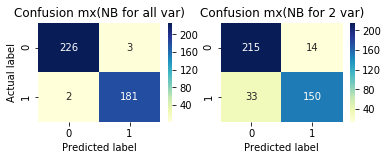

In [38]:
#_confusion matrix
plt.subplot(2,2,1)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predicted_l)), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion mx(NB for all var)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.subplot(2,2,2)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, predicted_lc)), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion mx(NB for 2 var)')
#plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Here we can see model having four vairables is better than two variables. This is surprising as Logistic Regression also assumes columns to be independent and not correlated. It would be interesting to see and investigate the reason behind it. The one reason behind this is might be a sample size which is very small. The other reason might be a case of overfitting as well in the first case(having accuracy of 99% approximately)

### b) Cross Validation

In [39]:
# cross validation for all variables
scores = cross_val_score(logisticRegr, attribute_X, target_y.values.ravel(), cv=10)
print("*********Accurracy for all covariates********")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Acuuracy range :", np.min(scores),"-",np.max(scores))
print("*********Accurracy for two covariates********")
# cross validation for two variables
scores = cross_val_score(logisticRegr, attribute_X_c, target_y.values.ravel(), cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Acuuracy range :", np.min(scores),"-",np.max(scores))

*********Accurracy for all covariates********
Accuracy: 0.99 (+/- 0.02)
Acuuracy range : 0.9708029197080292 - 1.0
*********Accurracy for two covariates********
Accuracy: 0.88 (+/- 0.04)
Acuuracy range : 0.8540145985401459 - 0.9124087591240876


### c) significance of the covariates (To check the significance of covariates by beta value and p value)

In [40]:
logit = sm.Logit(y_train_c,X_train_c)
logistic_regression_results = logit.fit()
print(logistic_regression_results.summary())

Optimization terminated successfully.
         Current function value: 0.267721
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  960
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                            1
Date:                Tue, 25 Dec 2018   Pseudo R-squ.:                  0.6103
Time:                        23:46:03   Log-Likelihood:                -257.01
converged:                       True   LL-Null:                       -659.56
                                        LLR p-value:                4.222e-177
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
variance      -1.0698      0.074    -14.382      0.000      -1.216      -0.924
skewness      -0.2255      0.

In [41]:
logit = sm.Logit(y_train,X_train)
logistic_regression_results = logit.fit()

print(logistic_regression_results.summary())

Optimization terminated successfully.
         Current function value: 0.084601
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  960
Model:                          Logit   Df Residuals:                      956
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Dec 2018   Pseudo R-squ.:                  0.8769
Time:                        23:46:03   Log-Likelihood:                -81.217
converged:                       True   LL-Null:                       -659.56
                                        LLR p-value:                1.836e-250
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
variance      -2.9587      0.321     -9.216      0.000      -3.588      -2.330
skewness      -1.8448      0

* From this summary we can see that all covariates are significant as p value is 0 for all and 'variance' is most significant     covariate to predict the class variable. 
* One reason behind this Complete quasi-seperation is that one variable 'vairance' seems to be a very good predictor based on  the scatter plot.
* One can also note that as sample size is very small, standard error or P-value from MLE can be biased. So the model might be     not reliable for large sample size.


### d) McNemar Test (To compare the both classifier: Logistic Regression having 2 and 4 covariates)

In [42]:
# McNemar test 
# discrepancy table values
A=0 # when both classifier are correct
B=0 # when first classifier is incorrect and second is correct
C=0 # when first classifier is correct and second is incorrect
D=0 # when both classifiers are incorrect
# iterating values from the test set labels
y_test_class=np.array(y_test)
for index,true_lable in enumerate(y_test_class):
    if predicted_l[index]==true_lable and predicted_lc[index]==true_lable:
        A=A+1
    elif predicted_l[index]!=true_lable and predicted_lc[index]==true_lable:
        B=B+1
    elif predicted_l[index]==true_lable and predicted_lc[index]!=true_lable: 
        C=C+1
    elif predicted_l[index]!=true_lable and  predicted_lc[index]!=true_lable: 
        D=D+1
        
print("A",A)
print("B",B)
print("C",C)
print("D",D)
p_value = stats.binom_test(B, B+C, 0.5)
print("p value", p_value)    

A 365
B 0
C 42
D 5
p value 4.5474735088646407e-13


Here we can see that both classifier are significantly different at the significance level of 0.05. That mean classifier haiving  99% accuracy is better than the other one (having two covariates only).

## 3) Comparison of both Classifier

### a) McNeamer test (To compare the both classifier: Logistic Regression and Naive Bayes )

In [43]:
# McNemar test 
# discrepancy table values
A=0 # when both classifier are correct
B=0 # when first classifier is incorrect and second is correct
C=0 # when first classifier is correct and second is incorrect
D=0 # when both classifiers are incorrect
# iterating values from the test set labels
y_test_class=np.array(y_test)
for index,true_lable in enumerate(y_test_class):
    if predicted_l[index]==true_lable and predicted_c[index]==true_lable:
        A=A+1
    elif predicted_l[index]!=true_lable and predicted_c[index]==true_lable:
        B=B+1
    elif predicted_l[index]==true_lable and predicted_c[index]!=true_lable: 
        C=C+1
    elif predicted_l[index]!=true_lable and  predicted_c[index]!=true_lable: 
        D=D+1
        
print("A",A)
print("B",B)
print("C",C)
print("D",D)
p_value = stats.binom_test(B, B+C, 0.5)
print("p value", p_value)    

A 354
B 0
C 53
D 5
p value 2.220446049250313e-16


Here p value is tends to 0. That mean null hypothesis ( both classifiers are not different ) is rejected. That leads us to belive that Logistic Regression is working better on this dataset.

### b ) Comparing Sensitivity,Specificity and Accuracy 

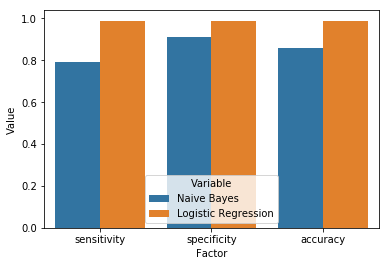

In [48]:
#Sensitivity = TP / (TP + FN) 
#Specificity = TN / (TN + FP) 
#Accuracy = (TP + TN) / (TP+FP+TN+FN)

# For Naive Bayes Classification
# from the earlier confusion matrix(having two classifier and approximately 85% accuracy)
n_TP = 145 
n_TN = 209
n_FP = 20
n_FN = 38

n_sensitivity = n_TP/(n_TP + n_FN)
n_specificity = n_TN/(n_TN + n_FP)
n_accuracy = (n_TP + n_TN) / (n_TP + n_FP + n_TN + n_FN)
                        
# For Logistic Classification
# from the earlier confusion matrix(having four classifier and aproximately 99% accuracy)
                        
l_TP = 181
l_TN = 226
l_FP = 3
l_FN = 2

l_sensitivity = l_TP/(l_TP + l_FN)
l_specificity = l_TN/(l_TN + l_FP)
l_accuracy = (l_TP + l_TN) / (l_TP + l_FP + l_TN + l_FN)
# making a new data type for plotting
comparison_df = pd.DataFrame({
    'Factor': ['sensitivity', 'specificity' , 'accuracy'],
    'Naive Bayes': [n_sensitivity, n_specificity,n_accuracy],
    'Logistic Regression': [l_sensitivity, l_specificity,l_accuracy]
})
# modification in data to make it suitable for easy plot
target_df = (
    comparison_df.set_index('Factor')
      .stack()  # un-pivots the data 
      .reset_index()  # moves all data out of the index
      .rename(columns={'level_1': 'Variable', 0: 'Value'})
)
sns.barplot(x='Factor', y='Value', hue='Variable', data=target_df)

Here we can see that Logistic Regression is bettter that Naive Bayes Classifier on all three parameters for this dataset.